In [1]:
import os
import sys
sys.path.append('../mlai_research/')
import log
import utils
import cv2
import numpy as np
from skimage import feature
from skimage.feature import graycomatrix, graycoprops
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.measure import regionprops
from rasterio.mask import mask
import geopandas as gpd
import rasterio
import rasterio.plot
import glob
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Union

In [2]:
logger = log.get_logger(__name__)

In [3]:
conf = utils.load_config("base")

24-Dec-23 18:24:41 - INFO - Starting 'load_config'.
24-Dec-23 18:24:41 - INFO - Finished 'load_config' in 0.0715 secs.


In [4]:
def load_rgb_images(image_paths: List[str]) -> List[np.ndarray]:
    """
    Load RGB images from the provided paths.

    Parameters:
    - image_paths (List[str]): List of paths to the images.

    Returns:
    - List[np.ndarray]: List of loaded images.
    """
    images = []
    for path in image_paths:
        with rasterio.open(path) as src:
            img = src.read()
            image_data = np.transpose(img, (1, 2, 0))
            rgb = image_data[:, :, :3]
        images.append(rgb)
    logger.info(f'Loaded RGB img shape: {images[0].shape}')
    return images


def load_grayscale_images(image_paths):
    images = []
    for path in image_paths:
        img = np.load(path)
        images.append(img)
    return np.array(images)


def load_hyperspectral_images(image_paths):
    images = []
    for path in image_paths:
        with rasterio.open(path) as src:
            img = src.read()
            # Transpose the image to have channels last
            # img = img.transpose((1, 2, 0))
            images.append(img)
    return images


def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalizes the pixel values of the input image.

    Parameters:
    - image (numpy.ndarray): The input image.

    Returns:
    - numpy.ndarray: The normalized image.
    """
    # Normalize the image to the range [0, 255]
    normalized_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return normalized_image


def create_center_segment_mask(segmentation: np.ndarray, image_shape: Tuple[int, int]) -> np.ndarray:
    # Step 1: Identify the center point of the image
    center_point = (image_shape[0] // 2, image_shape[1] // 2)
    # Step 2: Identify the segment label at the center point
    center_segment_label = segmentation[center_point]
    # Step 3: Create a mask by comparing the segmentation array with the center segment label
    mask = segmentation == center_segment_label
    logger.info(f'Mask shape: {mask.shape}')
    return mask


def apply_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    # Ensure mask is boolean
    mask = mask.astype(bool)

    # If the image has more than one channel, we need to adjust the mask to have the same number of channels
    if image.ndim > 2:
        # Expand dimensions of the mask to match the image
        mask = np.stack([mask]*image.shape[-1], axis=-1)

    # Apply the mask to the image
    masked_image = image * mask
    return masked_image


def plot_masked_images_segments(image_dict, save = False, out_dir = None, fn = None):
    num_images = len(image_dict['original'])
    
    # Set up the plot with num_images rows and 3 columns
    fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(12, 4*num_images))

    for i in range(num_images):
        # Plot the original image in the first column
        axes[i, 0].imshow(image_dict['original'][i])
        axes[i, 0].set_title('Original Image')

        # Plot the segmented image with boundaries in the second column
        axes[i, 1].imshow(mark_boundaries(image_dict['original'][i], image_dict['segmented'][i]))
        axes[i, 1].set_title('Segmented Image')

        # Plot the masked image in the third column
        axes[i, 2].imshow(image_dict['masked'][i])
        axes[i, 2].set_title('Masked Image')

    if save:
        utils.save_plot(fig, f"{out_dir}segmented_{fn}.png")
        logger.info(f"Saved plot to {out_dir}segmented_{fn}.png")
    else:
        plt.tight_layout()
        plt.show()


# def create_plant_mask(image: np.ndarray, segments: np.ndarray) -> np.ndarray:
#     # Convert the image to the HSV color space
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
#     # Define the range of green colors in HSV
#     lower_green = np.array([35, 100, 100])
#     upper_green = np.array([85, 255, 255])
    
#     # Create a binary mask that separates green pixels from the rest of the image
#     green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
#     # Apply the Felzenszwalb segmentation to the binary mask
#     segments = felzenszwalb(green_mask, scale=100, sigma=0.5, min_size=50)
    
#     # Initialize an empty mask to store the plant segments
#     plant_mask = np.zeros_like(green_mask, dtype=bool)
    
#     # Analyze each segment
#     for segment_label in np.unique(segments):
#         # Get the current segment
#         segment = segments == segment_label

#         # Calculate texture features of the segment
#         glcm = graycomatrix(segment.astype(np.uint8), [1], [0], levels=256, symmetric=True, normed=True)
#         contrast = graycoprops(glcm, 'contrast')[0, 0]
        
#         # If the segment meets certain criteria (e.g., low contrast), add it to the plant mask
#         if contrast < 0.02:
#             plant_mask = plant_mask | segment
        
#         # # Calculate features of the segment
#         # region = regionprops(segment.astype(int))[0]
        
#         # # If the segment meets certain criteria (e.g., size, shape, color), add it to the plant mask
#         # # This is where you would add your own criteria based on your knowledge of the plants
#         # if region.area > 100:
#         #     plant_mask = plant_mask | segment
    
#     return plant_mask.astype(np.uint8) * 255
        

def create_plant_mask(image: np.ndarray, segments: np.ndarray) -> np.ndarray:
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the range of green colors in HSV
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    
    # Create a binary mask that separates green pixels from the rest of the image
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    # Initialize an empty mask to store the plant segments
    plant_mask = np.zeros_like(green_mask, dtype=bool)
    
    # Analyze each segment
    for segment_label in np.unique(segments):
        # Get the current segment
        segment = segments == segment_label

        # Calculate the proportion of green pixels in the segment
        green_proportion = np.mean(green_mask[segment])

        # If the segment is mostly green, add it to the plant mask
        if green_proportion > 0.6:
            plant_mask = plant_mask | segment
    
    return plant_mask.astype(np.uint8) * 255


def segment_rgb(rgb_imgs: List[np.ndarray]) -> Tuple[Dict[str, List[np.ndarray]], List[np.ndarray]]:
    """
    Segment RGB images using the Felzenszwalb's efficient graph based segmentation.

    Parameters:
    - rgb_imgs (List[np.ndarray]): List of RGB images.

    Returns:
    - Tuple[Dict[str, List[np.ndarray]], List[np.ndarray]]: Tuple containing a dictionary of original, segmented, and masked images, and a list of masks.
    """
    rgb_dct = {'original': [], 'segmented': [], 'masked': []}
    masks = []
    for rgb_img in rgb_imgs:
        # Step 1: Normalize the image
        normalized_image = normalize_image(rgb_img)

        # Step 2: Segment the normalized image
        segments = felzenszwalb(normalized_image, scale=100, sigma=0.5, min_size=50)
        segments.shape

        # Step 3: Create a mask based on the center segment
        # mask = create_center_segment_mask(segments, normalized_image.shape[:2])
        mask = create_plant_mask(normalized_image, segments)
        masks.append(mask)

        # Step 4: Apply the mask to the normalized image
        masked_image = apply_mask(normalized_image, mask)

        # Step 5: Plot the images
        rgb_dct['original'].append(normalized_image)
        rgb_dct['segmented'].append(segments)
        rgb_dct['masked'].append(masked_image)
    logger.info(f'Original shape: {rgb_dct["original"][0].shape}')
    logger.info(f'Mask shape: {masks[0].shape}')
    logger.info(f'Segmented shape: {rgb_dct["segmented"][0].shape}')
    return rgb_dct, masks

In [5]:
rgb_fns = utils.get_filenames(conf.data.path_int_cr_tif, "tif", 'rgb')
chm_fns = utils.get_filenames(conf.data.path_int_cr_tif, "npy", 'chm')
hyps_fns = utils.get_filenames(conf.data.path_int_cr_tif, "tif", 'hyps')

In [6]:
rgb_fns = utils.get_filenames(conf.data.path_int_cr_tif, "tif", 'rgb')
rgb_imgs = load_rgb_images(rgb_fns[:50])

24-Dec-23 18:24:42 - INFO - Loaded RGB img shape: (87, 87, 3)


In [7]:
rgb_dct, masks = segment_rgb(rgb_imgs)

24-Dec-23 18:24:42 - INFO - Original shape: (87, 87, 3)
24-Dec-23 18:24:42 - INFO - Mask shape: (87, 87)
24-Dec-23 18:24:42 - INFO - Segmented shape: (87, 87)


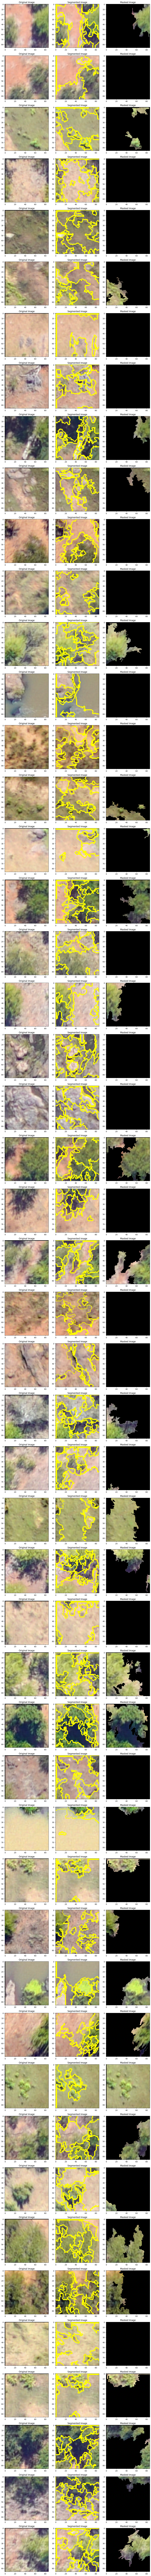

In [8]:
plot_masked_images_segments(rgb_dct, save=False, out_dir=conf.data.path_rep, fn=conf.data.fn_rgba)

In [ ]:
# with rasterio.open("../data/02_intermediate/03_cropped_tifs/279_rgb_xan.tif") as src:
#     img = src.read()
#     image_data = np.transpose(img, (1, 2, 0))
#     rgb = image_data[:, :, :3]
# img.shape, image_data.shape, rgb.shape

In [ ]:
normalized_image = normalize_image(rgb)
normalized_image.shape

In [ ]:
segments = felzenszwalb(normalized_image, scale=100, sigma=0.5, min_size=50)
segments.shape

In [ ]:
plant_mask = create_plant_mask(normalized_image, segments)

In [ ]:
# mask = create_center_segment_mask(segments, normalized_image.shape[1:])
# mask.shape

In [ ]:
# Step 4: Apply the mask to the normalized image
# masked_image = apply_mask(normalized_image, mask)
masked_image = apply_mask(normalized_image, plant_mask)

In [ ]:
rgb_dct = {'original': [rgb, rgb], 'segmented': [segments, segments], 'masked': [masked_image, masked_image]}

In [ ]:
plot_masked_images_segments(rgb_dct, save=True, out_dir=conf.data.path_rep, fn=conf.data.fn_rgba)